Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`.

In [27]:
import sys
print(sys.path)

['C:\\Users\\ML2618\\PycharmProjects\\HexSimInstrument', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\python38.zip', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\DLLs', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib', '', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages', 'C:\\Users\\ML2618\\PycharmProjects\\napari-pcd-reader_draft\\src', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32\\lib', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\Pythonwin']


In [28]:
import numpy as np
import cupy as cp
from scipy.signal import convolve2d
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2

# Aberration correction simulation

In [29]:
xp = cp
# titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Unwrapped PSF phase difference', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus'
titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Zernike fitted phase', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus']

Set up arrays

In [30]:
N = 256
x, y = xp.meshgrid(xp.linspace(-1, 1, N), xp.linspace(-1, 1, N))
r = xp.sqrt(x ** 2 + y ** 2)
theta = xp.arctan2(y, x)
circ = r < 1
g = xp.exp(-r ** 2 / 2 / (0.5 ** 2))  # weight the target PSF towards the centre
G = xp.zeros((int(2 * N), int(2 * N)))
G[int(N / 2): int(3 * N / 2), int(N / 2): int(3 * N / 2)] = g
normval = xp.sum(circ)

Zernike aberrations

In [31]:
Z00 = xp.ones_like(x) * circ
Z11 = 2 * r * xp.cos(theta) * circ
Z1_1 = 2 * r * xp.sin(theta) *circ
Z20 = xp.sqrt(3) * (2 * r ** 2 - 1) * circ
Z22 = xp.sqrt(6) * r ** 2 * xp.cos(2 * theta) * circ
Z2_2 = xp.sqrt(6) * r ** 2 * xp.sin(2 * theta) * circ
Z31 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.cos(theta) * circ
Z3_1 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.sin(theta) * circ
Z33 = 2 * xp.sqrt(2) * r ** 3 * xp.cos(3 * theta) * circ
Z3_3 = 2 * xp.sqrt(2) * r ** 3 * xp.sin(3 * theta) * circ
Z40 = xp.sqrt(5) * (6 * r ** 4 - 6 * r ** 2 + 1) * circ
Z42 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.cos(2 * theta) * circ
Z4_2 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.sin(2 * theta) * circ
Z44 = xp.sqrt(10) * r ** 4 * xp.cos(4 * theta) * circ
Z4_4 = xp.sqrt(10) * r ** 4 * xp.sin(4 * theta) * circ
Z51 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.cos(theta) * circ
Z5_1 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.sin(theta) * circ
Z53 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.cos(3 * theta) * circ
Z5_3 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.sin(3 * theta) * circ
Z55 = xp.sqrt(12) * r ** 5 * xp.cos(5 * theta) * circ
Z5_5 = xp.sqrt(12) * r ** 5 * xp.sin(5 * theta) * circ

## SLM's aberration
### Random phase
Create a random image with low spatial frequency content for aberration to be measured

In [32]:
# ri0 = xp.random.rand(N, N) - 0.5
# kern = xp.reshape(xp.exp(-r ** 2 / (2 * 0.35 ** 2)), (N, N))
# if xp == cp:
#     ri = xp.array(convolve2d(ri0.get(), kern.get(), mode='same')) * circ / 2
# else:
#     ri = convolve2d(ri0, kern, mode='same') * circ / 1
# % ri = imresize(ri,10,'bicubic')
# % ri = 1.0*ri(9*N/2:11*N/2-1,9*N/2:11*N/2-1).*circ+atan2(y-0.5,x-0.3).*circ-atan2(y+0.4,x-0.3).*circ
# % ri = (2*ri(9*N/2:11*N/2-1,9*N/2:11*N/2-1)+2*Z40+2*Z11+1*Z2_2+2*Z11).*circ
ri = (30 * Z22 + 2 * Z2_2 - 5 * Z31 + 7 * Z3_1 + 5 * Z33 - 2 * Z3_3)*circ / 2

# for the starting test aberration
# x2, y2 = xp.meshgrid(xp.linspace(-0.2, 0.2, N), xp.linspace(-0.2, 0.2, N))
# r2 = xp.sqrt(x2 ** 2 + y2 ** 2)  # starting random input phase
# r2 = xp.sqrt(x ** 2 + y ** 2)  # starting random input phase
# ri2 = xp.random.rand(N, N) - 0.5
ri2 = (-18 * Z11 + 5 * Z22 - 7 * Z31 + 11 * Z3_3) * circ
# kern = xp.exp(-r2 ** 2 / (2 * 0.35 ** 2))
# if xp == cp:
#     ri2 = xp.array(convolve2d(ri2.get(), kern.get()))
# else:
#     ri2 = convolve2d(ri2, kern)
# ri2 = xp.reshape(ri2,ri2.shape * 10)
# ri2 = 1.0 * ri2[int(N / 2):int(3 * N / 2), int(N / 2):int(3 * N / 2)] * circ

Work out measured PSFs for the 3 applied masks

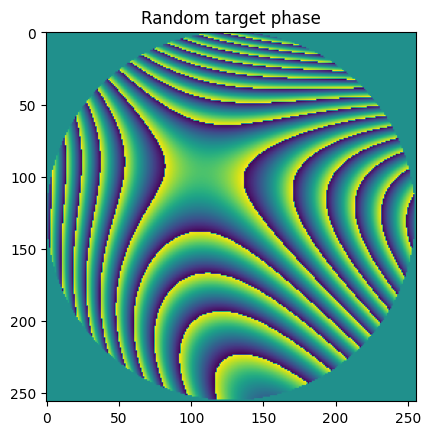

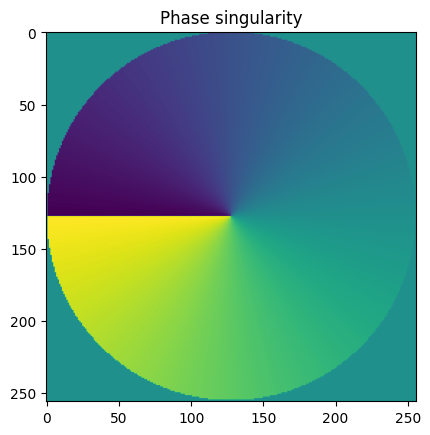

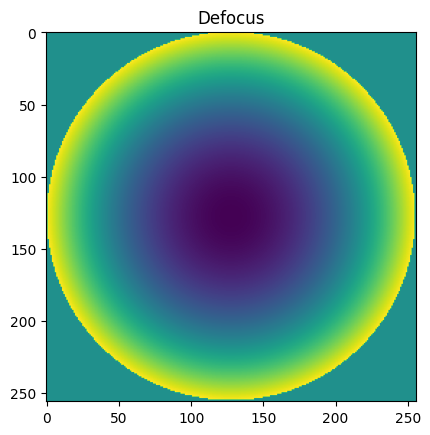

In [33]:
plt.figure(100)
if xp == cp:
    plt.imshow((xp.angle(xp.exp(1j * ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * ri)))
plt.title('Random target phase')

sumc = xp.sum(circ)
piston = xp.sum(xp.sum(ri * circ)) / sumc
diff = (ri-piston) * circ
rms = xp.sqrt(xp.sum(diff ** 2) / sumc)
# imshow(diff.*circ,[])
# text(0,-10,sprintf('max-min=%f, rms=%f, rmswaves=%f',max(diff(:))-min(diff(:)),rms,rms/2/pi))

plt.figure(101)
hlx = theta * circ  # helical wavefront
if xp == cp:
    plt.imshow(hlx.get())
else:
    plt.imshow(hlx)
plt.title('Phase singularity')

plt.figure(102)
defocus = 10 * Z20
if xp == cp:
    plt.imshow(defocus.get())
else:
    plt.imshow(defocus)
plt.title('Defocus')

#% ampl=circ
#% ampl=circ.*(1+x/3);  % a tilt in intensity accross the pupil
ampl = circ * xp.exp(-((x - 0.25) ** 2 + 2 * y ** 2) / 2 / 1 ** 2)  # funny gaussian illumination to simulater a laser beam scenario; sigma=1

In [34]:
nphot = 1e8  # Number of photons per detected image
bg = xp.ones((int(2*N), int(2*N)))  # background

### 3 PSFs
Apply three masks

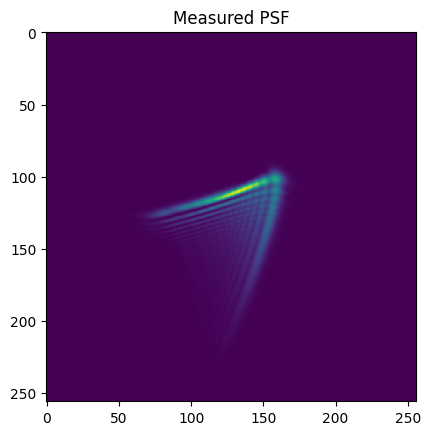

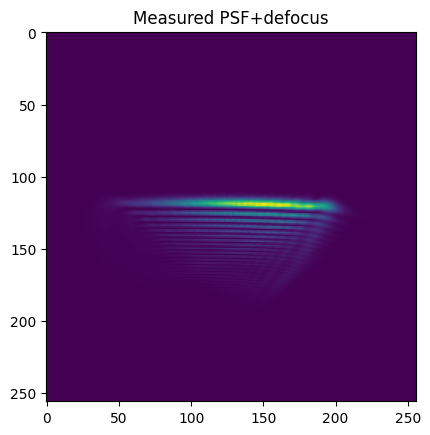

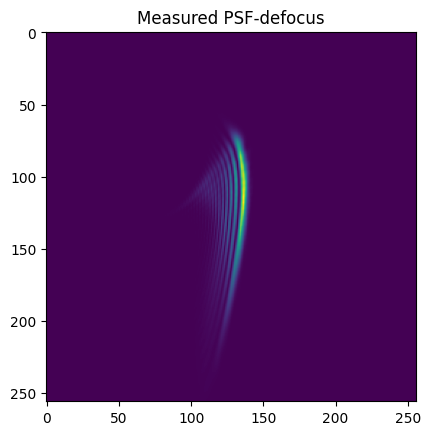

In [35]:
masks = [ri, ri + defocus, ri-defocus]
psfi = [None, None, None]  # psf intensity
psfn = [None, None, None]
for i in range(3):
    p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * masks[i]), (2*N, 2*N)))
    p1i = xp.abs(p1) ** 2 / xp.sum(xp.abs(p1) ** 2) * nphot + bg
    p1i_n = (xp.random.poisson(p1i) - bg) * G
    ps = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]  # PSF intensity with noise
    plt.figure(111 + i)
    plt.title(titles[9 + i])
    if xp == cp:
        plt.imshow(ps.get())
    else:
        plt.imshow(ps)
    psfi[i] = p1i_n + 0j

## Iteration loop to correct aberrations

In [36]:
cumphase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)

In [37]:
show_ani = False
if show_ani:
    f = plt.figure(figsize=(20,20))

    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        if not title is None:
            axes[k].set_title(title)
        if k == 11:
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())
#             display.display([axis.get_figure() for axis in axes])

t0 = time.time()
nits = 1
n = 40
error = 0
psfn0 = [None, None, None]
sumc = xp.sum(circ)

while nits < 501:
    q1 = xp.fft.fftshift(xp.fft.fft2(Q, (2 * N, 2*N)))
    q2 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * defocus), (2*N, 2*N)))
    q3 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * (-defocus)), (2*N, 2*N)))
    q1s = q1[int(1*N/2-1):int(3*N/2), int(1*N/2-1):int(3*N/2)]

    if xp.mod(nits, n) == 0:
        show_animation(0,abs(q1s) ** 2)

    Q1 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[0]) * xp.exp(1j * xp.angle(q1))))
    Q1[:N, :N] = Q1[:N, :N] * circ
    Q2 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[1]) * xp.exp(1j * xp.angle(q2))))
    Q2[:N, :N] = Q2[:N, :N] * circ * xp.exp(-1j * defocus)
    Q3 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[2]) * xp.exp(1j * xp.angle(q3))))
    Q3[:N, :N] = Q3[:N, :N] * circ * xp.exp(1j * defocus)

    Q = Q1[:N, :N] + Q2[:N, :N] + Q3[:N, :N]

# %     Q=Q2(1:N,1:N)+Q3(1:N,1:N)

    if xp.mod(nits, n) == 0:
        show_animation(1,xp.angle(Q))

    if xp.mod(nits,n) == 0:
#         show_animation(2, diff * circ)
        diff = xp.angle(Q * xp.exp(-1j * ri))
        piston = xp.sum(diff * circ) / sumc
        diff = (diff-piston) * circ
        rms= xp.sqrt(xp.sum(diff ** 2) / sumc)
        show_animation(2, diff)

#         show_animation(3, xp.sqrt(abs(Q)))
        show_animation(3, abs(Q))

        if show_ani:
            axes[4].clear()
            if xp == cp:
                axes[4].plot(xp.squeeze(abs(Q.get()[N//2,:])))
            else:
                axes[4].plot(xp.squeeze(abs(Q[N//2,:])))
#             display.clear_output(wait=True)
#             display.display(axes[4].get_figure())

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    Qa = abs(Q)
    Qb = xp.sum(Qa * Z00) * Z00
    z_a_i = [Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z40, Z42, Z4_2, Z44, Z4_4]  # Zernike aberration for intensity
    for i in z_a_i:
        Qb = Qb + xp.sum(Qa * i) * i

    Qc = xp.angle(Q)
    Q = Qb * xp.exp(1j*Qc) / sumc
    if xp.mod(nits, n) == 0:
        q = xp.angle(Q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q = xp.flipud(q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.fliplr(q)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.flipud(xp.fliplr(q))
        show_animation(5,xp.angle(xp.exp(1j * ri)))
    #         plt.text(0, -10, 'nits=%d , rms=%f, rmswaves=%f' % (nits, rms, rms / 2 / xp.pi))

        diff = q
        piston = xp.sum(diff * circ)/sumc
        diff = (diff-piston) * circ
        rms = xp.sqrt(xp.sum(diff ** 2) / sumc)
        show_animation(6, diff, f'rms = {rms:.3f}')
    #         plt.text(0, -10, 'nits=%d , rms=%f, rmswaves=%f' % (nits, rms, rms / 2 / xp.pi))

        Qc = q

        # Constrain phase in pupil to have slowly varying values by fitting to Zernike
        Qd = xp.sum(Qc * Z00) * Z00
        z_a_p = [Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55,Z5_5]  # Zernike aberration for phase
        for i in z_a_p:
            Qd = Qd + xp.sum(Qc * i) * i
        Qd=Qd/normval

        fac = 2
        Q = abs(Q) * xp.exp(1j * Qd * (1-1 / fac))
    #         I think the cumphase used in the measured PSFs should be the unwrapped phase ratherthan the Zernike fitted phase. 
    #         Q = abs(Q) * xp.exp(1j * Qc * (1-1 / fac))
        # Q = abs(Q).*exp(1i*Qd)
        show_animation(7, Qd)
    # %         def = 0.9 * def;

        cumphase = cumphase + Qd/fac
    #         I think the cumphase used in the measured PSFs should be the unwrapped phase ratherthan the Zernike fitted phase. 
    #         cumphase = cumphase + Qc/fac
        show_animation(8, xp.angle(xp.exp(1j * cumphase)))


        new_masks = [ri - cumphase, ri - cumphase + defocus, ri - cumphase - defocus]     

        for i in range(3):
            p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * new_masks[i]), (2 * N, 2 * N)))
            p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
            p1i_n = (xp.random.poisson(p1i) - bg) * G
            ps = p1i_n[int(N / 2 - 1):int(3 * N / 2 - 1), int(N / 2 - 1):int(3 * N / 2 - 1)]
            show_animation(9+i,ps)
            psfi[i] = p1i_n + 0j
    nits = nits + 1

print(f'Elapsed time: {time.time() - t0}s')

Elapsed time: 2.343714475631714s


In [882]:
# if not show_ani:
#     imgs = []
#     fig = plt.figure()
#     for i in range(12):
#         plt.subplot(6, 2, i)
#         if xp == cp:
#             plt.imshow()
#         plt.imshow()
#         plt.title(titles[i])

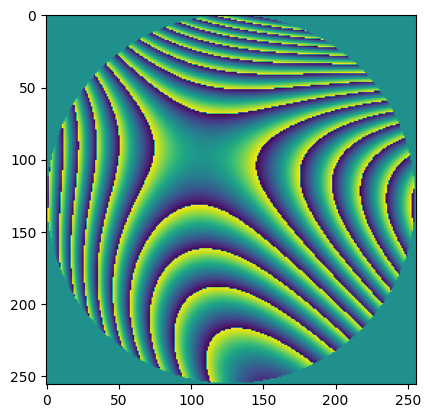

In [38]:
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (cumphase))).get())
#     plt.imshow(cumphase.get())
# plt.figure()
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

True

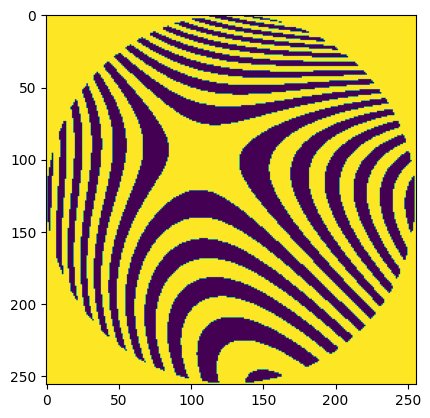

In [42]:
bi_phi = (xp.real(xp.exp(1j * cumphase))) > 0 * xp.pi
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))))
hol = xp.angle(xp.exp(1j * (bi_phi))).get()
cv2.imwrite('hol_test.png', hol, [cv2.IMWRITE_PNG_BILEVEL, 1])

Text(0.5, 1.0, 'Random target phase')

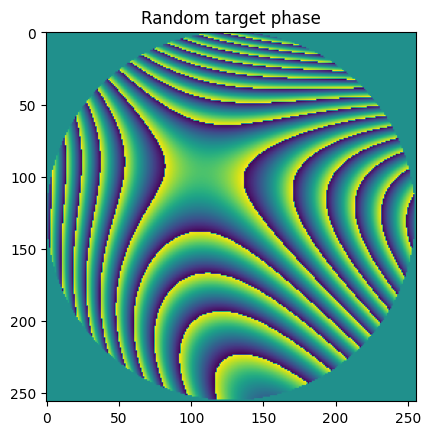

In [43]:
plt.figure(100)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (ri))))
plt.title('Random target phase')

In [44]:
# zs = xp.zeros((1,21))
# Qc = cumphase

# # Constrain phase in pupil to have slowly varying values by fitting to Zernike
# Z_list = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55, Z5_5]

# for i in range(21):
#     zs[0, i] = xp.sum(Qc * Z_list[i])
# zs = zs/normval

Tried to make the retrived phase bianary, but failed. The PSF is too good to believe.

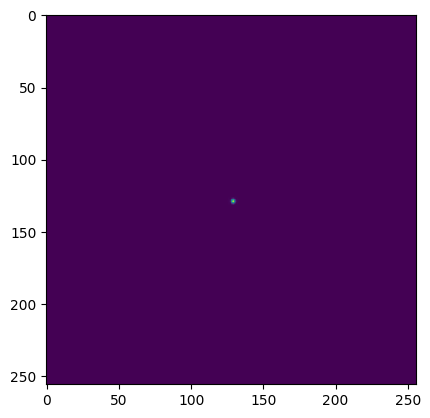

In [45]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

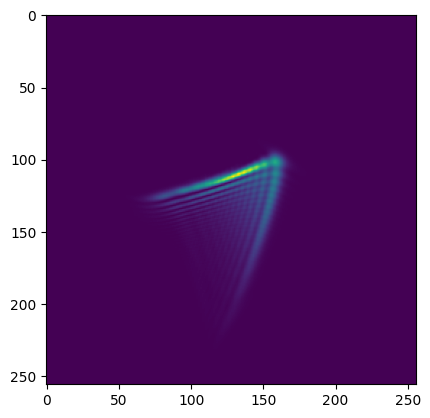

In [46]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

In [20]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [1175]:
print(psfi[0][138])

[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.         

In [984]:
bi_phi.mean()

array(57.22026953)

In [985]:
ri.mean()

array(1.00986456)

In [986]:
cumphase.mean()

array(-18.65401583)

In [968]:
ri.max() -ri.min()

array(61.30535486)

In [987]:
cumphase.max() -cumphase.min()

array(61.84224315)

In [988]:
bi_phi.max() - bi_phi.min()

array(1.)

In [989]:
np.max(cumphase)

array(5.01079808)

In [564]:
xp.sum(psfi[0])

array(69116157.32964002+0.j)

In [475]:
cumphase_norm.max()

array(6.25224269)